# Domain quantization 3

Build a torch nn module (layer) that does domain quantization

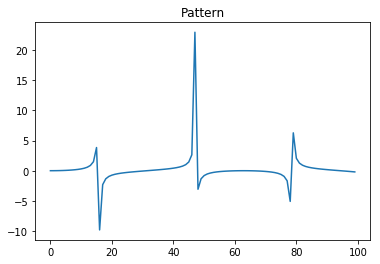

In [94]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

def normal_distribution(n, mean, var=0.05):
    x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
    x = x / np.sum(x)
    #return torch.tensor(x).float()
    return x
        
def create_pattern(pattern_length=100):
    pattern_floats = torch.tensor((np.sin(np.arange(pattern_length) * 0.05) * np.tan(np.arange(pattern_length) * .1) + np.random.sample(int(pattern_length)) * 0.0) / 2.5).float()

    fig, ax1 = plt.subplots()
    plt.title('Pattern')
    ax1.plot(pattern_floats.numpy())
    plt.show()

    return pattern_floats

pattern_floats = create_pattern()
pattern_floats = pattern_floats.unsqueeze(0)

- Each of the input features is expected to be a real number representing value of a variable
- Quantization is computed with given resolution
- Output is a sharp gradient at the quantized value for each input feature. Output shape is (# of input features, resolution)

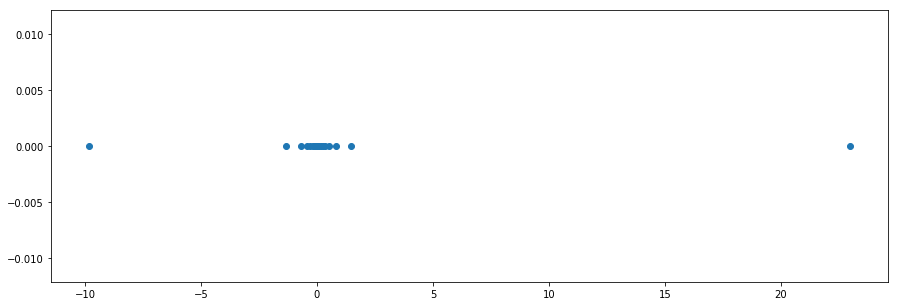

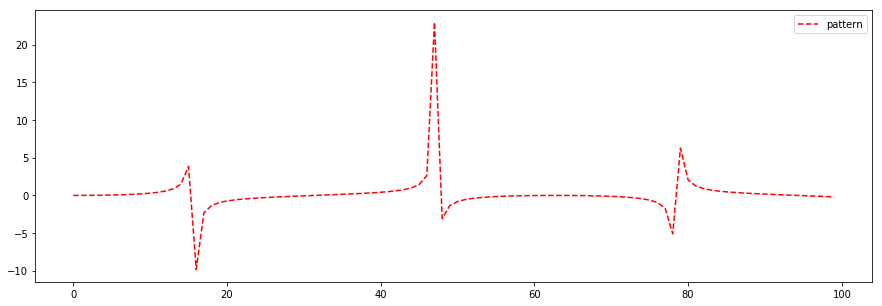

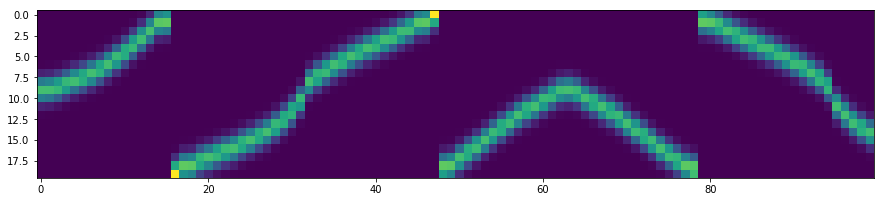

In [125]:
import pandas as pd

class DomainQuantizationLayer(nn.Module):
    def __init__(self, input_features, bin_count=10, init_low_bound=0.0, init_high_bound=1.0):
        assert bin_count > 1

        super().__init__()
        self.input_features = input_features
        self.bin_count = bin_count
        self.bins = torch.Tensor(input_features, bin_count)
        self.bins_initialized = False

    def forward(self, input):
        # print('input shape = ', input.shape)
        if self.training or not self.bins_initialized:
            self.update_bins(input)
        return self.map_values(input)

    def extra_repr(self):
        return f"input_features = {self.input_features}, resolution = {self.resolution}"
    
    def qcut_bins(self, values):
        assert len(values.shape) == 1, "Need 1D numpy array of values"
        _, bins = pd.qcut(values, q=self.bin_count-1, retbins=True)
        return bins

    def map_values(self, values):
        return torch.stack([self.map_feature_values(feature_values, feature_index) for feature_index, feature_values in enumerate(values)])
        
    def map_feature_values(self, values, feature_index):
        assert len(values.shape) == 1

        bins = self.bins[feature_index]
        digits = np.digitize(values, bins)
        output = digits.astype(float)
        for index, digit in enumerate(digits):
            if digit > 0 and digit < len(bins):
                val_left = bins[digit-1]
                val_right = bins[digit]
                output[index] += (values[index] - val_left) / (val_right - val_left)

        output -= 1
        output.clip(0, len(bins) - 1, out=output)
        output = [normal_distribution(self.bin_count, item * 1.0 / self.bin_count) for item in output]
        return torch.Tensor(output)
    
    def update_bins(self, values):
        for feature_index, feature_values in enumerate(values):
            self.update_feature_bins(feature_values, feature_index)
            
        self.bins_initialized = True
        
    def update_feature_bins(self, values, feature_index):
        alpha = 0.8
        bins = self.qcut_bins(values)
        if not self.bins_initialized:
            self.bins[feature_index] = torch.Tensor(bins)
        else:
            self.bins[feature_index] = self.bins[feature_index] * alpha + bins * (1 - alpha)
    
dq = DomainQuantizationLayer(1, bin_count=20)
output = dq(pattern_floats)

# show bins
fig, ax1 = plt.subplots(figsize=(15, 5))
bins = dq.bins[0].numpy()
ax1.scatter(bins, np.zeros_like(bins))
plt.show()

# show pattern
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(pattern_floats[0].numpy(), 'r--', label='pattern')
ax1.legend()
plt.show()


# show quantized output
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.imshow(np.flipud(output[0].numpy().transpose()))
plt.show()






Notes -

- quantization bins are closely packed where many data points are present, i.e. precision follows prevelence
- complex non-linear dynamics appear to get simplified as piecewise linear dynamics. For example, in above figure, dashed red line shows the pattern with exponential features. The blue line shows the domain quantized version of the signal, which appears to be simpler.